# training histories for AlexNet models trained with VSD

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

#### helper functions

In [2]:
def cm_to_inches(cm):
    return cm / 2.54

#### constants

In [3]:
SOURCE_DATA_ROOT = pyprojroot.here('results/VSD/source_data/')

FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-2/training-histories')

NET_NAME = 'CORnet_Z'

In [4]:
trainhist_csvs = sorted(SOURCE_DATA_ROOT.glob(f'training_history*{NET_NAME}*csv'))

In [5]:
df_trainhist = []
for trainhist_csv in trainhist_csvs:
    df_trainhist.append(pd.read_csv(trainhist_csv))
df_trainhist = pd.concat(df_trainhist)

#### make figures
first, figure in paper

In [6]:
RC= {'axes.labelsize': 6,
     'axes.titlesize': 6,
     'xtick.labelsize': 4,
     'ytick.labelsize': 4,
     'legend.fontsize': 4,   
     }

sns.set_style("darkgrid")
sns.set_context("paper", rc=RC)

DPI=300
FIGSIZE = tuple(cm_to_inches(size) for size in (13, 7.5))


COLUMNS = ['loss/train', 'loss/val', 'acc_largest/val', 'acc_random/val', 'f1/val']
COLUMN_TITLES = ['loss\n(train)', 'loss\n(val)', 'accuracy\n(largest object)', 'accuracy\n(random object)', 'f1 (macro)']

METHOD = 'transfer'
LOSS_FUNCS = ['CE_largest', 'CE_random', 'BCE']
LOSS_FUNC_ML_TASK_MAP = {
    'CE_largest': 'single-label, largest',
    'CE_random': 'single-label, random',
    'BCE': 'multi-label',  # <-- NOTICE DUMB HACK, have to add line break to get matplotlib to space all these in textboxes the same way
}


def trainhist(df_trainhist, 
              method=METHOD,
              figsize=FIGSIZE,
              dpi=DPI,
              save_root=FIGURES_ROOT,
              save_fig=False):
    assert method in {'transfer', 'initialize'}, f"method must be one of {'transfer', 'initialize'} but was {method}"

    df_trainhist = df_trainhist[df_trainhist.method == method]
    loss_funcs = df_trainhist.loss_func.unique()
    for loss_func in loss_funcs:
        assert loss_func in set(LOSS_FUNCS), f'all values for loss_func column in df_trainhist must be one of: {LOSS_FUNCS} but loss_func was {loss_func}'

    n_rows = len(LOSS_FUNCS)
    n_cols = len(COLUMNS)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    n_replicates = len(df_trainhist.replicate.unique())
    palette = sns.color_palette("Set2", n_colors=n_replicates)

    row = 0
    for loss_func in LOSS_FUNCS:
        df_lossfunc_trainhist = df_trainhist[df_trainhist.loss_func == loss_func]
        if len(df_lossfunc_trainhist) == 0:
            continue
        for col, (y, title) in enumerate(zip(COLUMNS, COLUMN_TITLES)):
            sns.lineplot(x='step', y=y, hue='replicate', data=df_lossfunc_trainhist, 
                         ci=None, legend=False, alpha=0.75, ax=ax[row, col], palette=palette,
                         linewidth=0.5);
            ax[row, col].set_ylabel('')
            ax[row, col].set_xlabel('')
            ax[row, col].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:0.2f}'))
            ax[row, col].tick_params(axis='both', which='both', length=0)  # turn off invisible ticks

            if row == 0:
                ax[row, col].set_title(title)

            if col == 0:
                ax[row, col].text(x=0, y=-0.25, s=LOSS_FUNC_ML_TASK_MAP[loss_func], 
                                  transform=ax[row, col].transAxes,
                                  fontweight='bold', 
                                  fontsize=4)

        ax[row, 1].set_ylim(ax[row, 0].get_ylim())
        ax[row, 2].set_ylim([0., 1.1])
        ax[row, 3].set_ylim([0., 1.1])
        ax[row, 4].set_ylim([0., 1.1])

        row += 1

    if row < n_rows - 1:
        print('yup')
        for row_left in range(row, n_rows):
            for ax_ in ax[row_left, :]:
                ax_.set_axis_off()
        
    # add a big axis, hide frame
    big_ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.grid(False)
    big_ax.set_xlabel("step", labelpad=0.1);

    # fig.tight_layout()
    
    if save_fig:
        net_name = df_trainhist.net_name.unique()
        assert len(net_name) == 1, 'did not find single unique net name in df_trainhist'
        net_name = net_name[0]
        
        for ext in ('svg', 'png'):
            fig_path = save_root.joinpath(
                f'training-history-{net_name}-{method}.{ext}'
            )
            plt.savefig(fig_path, bbox_inches='tight')

figure with all training histories

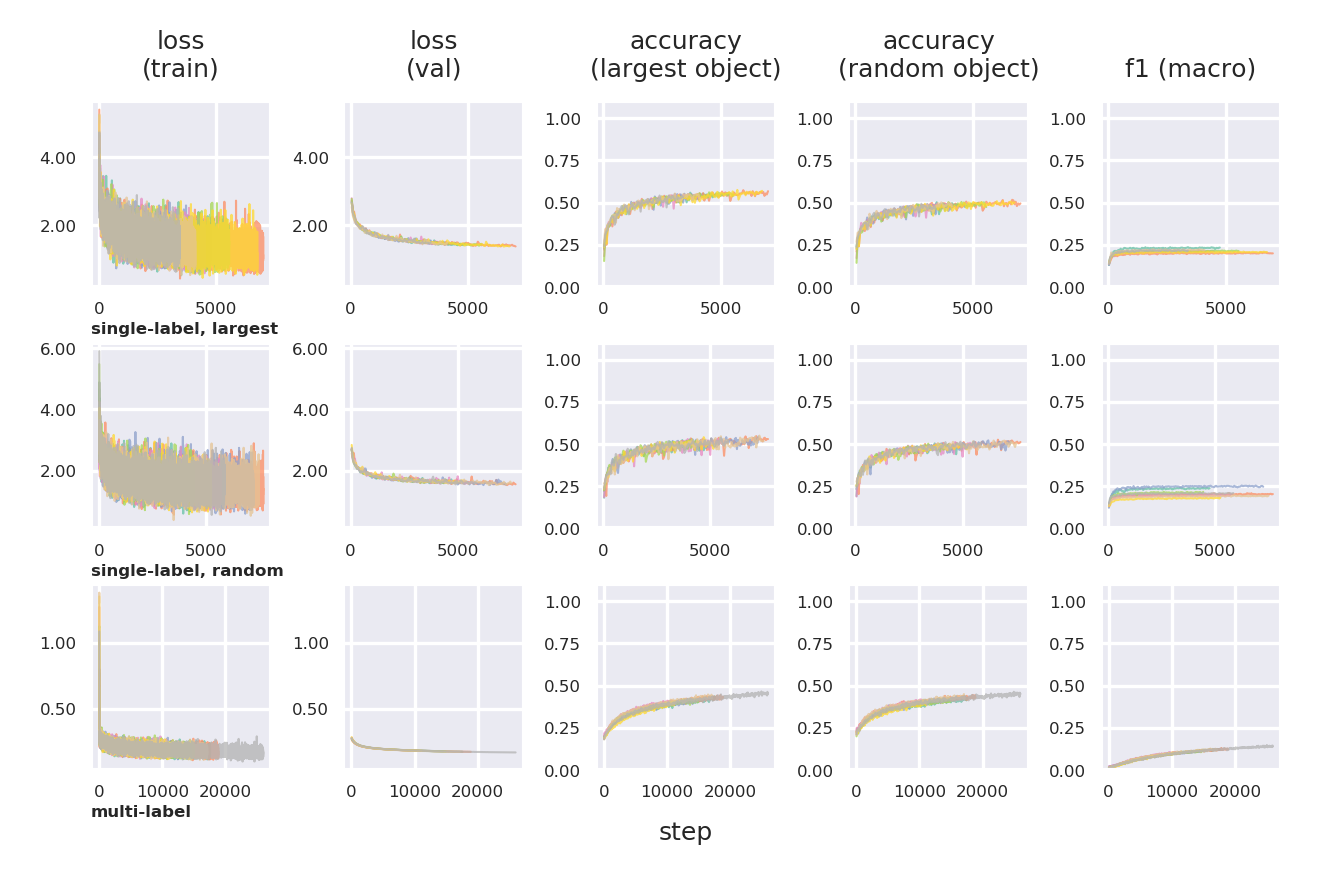

In [7]:
trainhist(df_trainhist, method='transfer', save_fig=True)

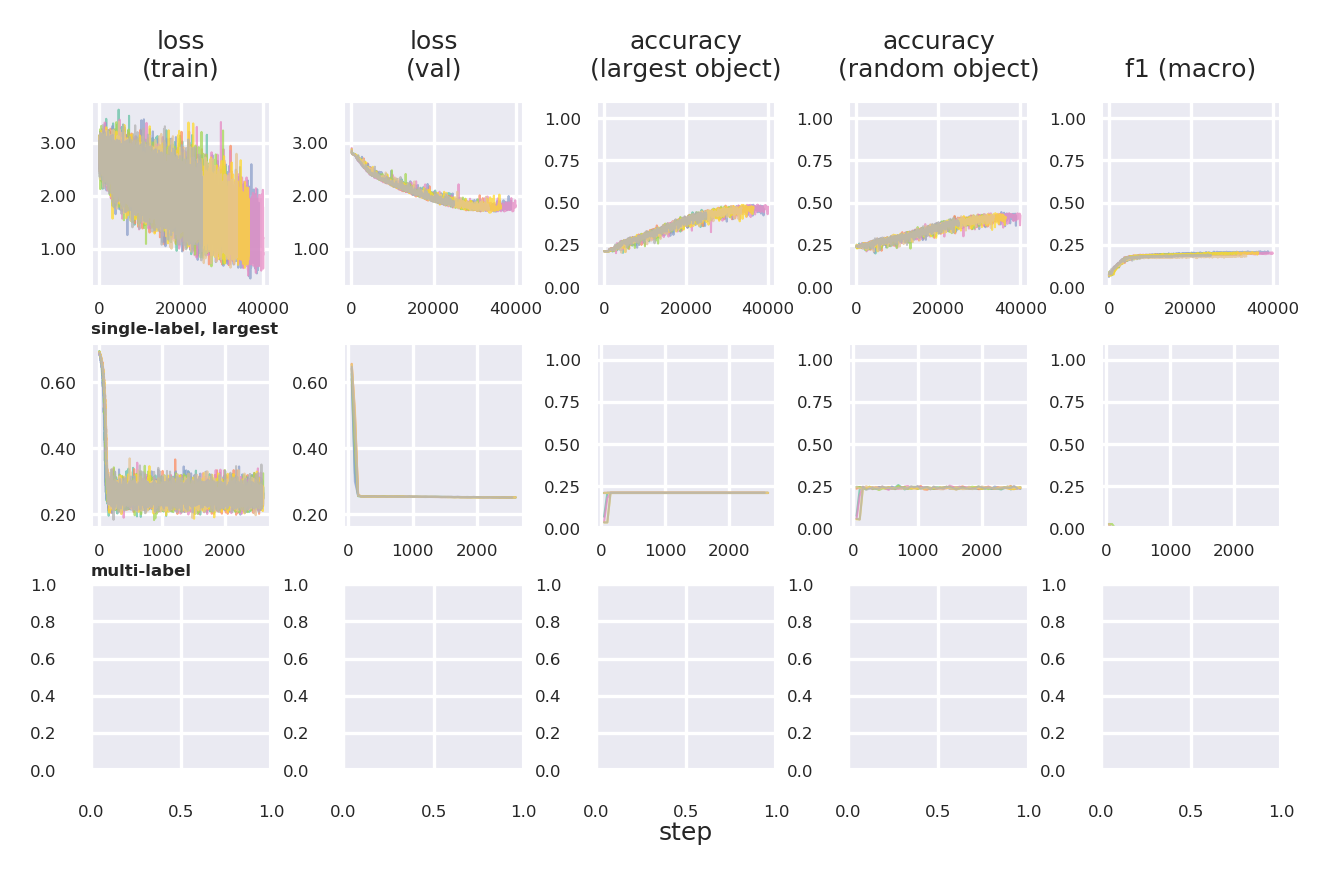

In [8]:
trainhist(df_trainhist, method='initialize', save_fig=True)